# Exploratory Data Analysis

Import dependencies, define a method

In [1]:
import os
from math import isnan

import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler

%load_ext Cython
import numba
numba.set_num_threads(4)
import pyarrow as pa
import pyarrow.parquet as pq


sns.set_theme()

LABEL_COLUMN_NAME = 'price'

### Load the data into a Pandas dataframe

Define the path to the dataset file

Define the name of the label column

In [2]:
filename = os.path.join(os.getcwd(), "data", "airbnb_readytofit.csv.gz")
df = pd.read_csv(filename, header=0,
                  dtype_backend='pyarrow',
                  engine='pyarrow')

Preview the first 5 rows

In [3]:
df.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,...,n_host_verifications,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,False,True,True,True,False,-0.578829,-2.845589,-0.054298,-0.054298,-1.007673,...,1.888373,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,False,True,True,True,False,-4.685756,-0.430024,-0.112284,-0.112284,0.067470,...,0.409419,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,False,True,True,True,False,0.578052,-2.473964,-0.112284,-0.112284,0.605041,...,-1.069535,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,False,True,False,True,False,0.578052,1.010024,-0.112284,-0.112284,-0.470102,...,-0.576550,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,False,True,True,True,False,-0.054002,-0.066308,-0.112284,-0.112284,-1.007673,...,0.902404,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Common statistics for features

In [4]:
# store the number of rows for use below
num_rows = df.shape[0]

# include non-numeric columns and other statistical data too:
df_desc = df.describe(include='all')

print(round(df_desc,2))

       host_is_superhost host_has_profile_pic host_identity_verified  \
count              28022                28022                  28022   
unique                 2                    2                      2   
top                False                 True                   True   
freq               21201                27891                  23540   
mean                 NaN                  NaN                    NaN   
std                  NaN                  NaN                    NaN   
min                  NaN                  NaN                    NaN   
25%                  NaN                  NaN                    NaN   
50%                  NaN                  NaN                    NaN   
75%                  NaN                  NaN                    NaN   
max                  NaN                  NaN                    NaN   

       has_availability instant_bookable  host_response_rate  \
count             28022            28022             28022.0   
unique 

### View the data types for all columns

In [5]:
df.dtypes

host_is_superhost                                 bool[pyarrow]
host_has_profile_pic                              bool[pyarrow]
host_identity_verified                            bool[pyarrow]
has_availability                                  bool[pyarrow]
instant_bookable                                  bool[pyarrow]
host_response_rate                              double[pyarrow]
host_acceptance_rate                            double[pyarrow]
host_listings_count                             double[pyarrow]
host_total_listings_count                       double[pyarrow]
accommodates                                    double[pyarrow]
bathrooms                                       double[pyarrow]
bedrooms                                        double[pyarrow]
beds                                            double[pyarrow]
price                                           double[pyarrow]
minimum_nights                                  double[pyarrow]
maximum_nights                          

### Infer the data types for all columns

Get insight into which features whose data types may have been improperly detected by Pandas and need to be changed.

In [6]:
# initialize an empty dict for storing results
types_dict = {}

for column in df.columns:
    types_dict[column] = pd.api.types.infer_dtype(df[column])

types_dict

{'host_is_superhost': 'boolean',
 'host_has_profile_pic': 'boolean',
 'host_identity_verified': 'boolean',
 'has_availability': 'boolean',
 'instant_bookable': 'boolean',
 'host_response_rate': 'floating',
 'host_acceptance_rate': 'floating',
 'host_listings_count': 'floating',
 'host_total_listings_count': 'floating',
 'accommodates': 'floating',
 'bathrooms': 'floating',
 'bedrooms': 'floating',
 'beds': 'floating',
 'price': 'floating',
 'minimum_nights': 'floating',
 'maximum_nights': 'floating',
 'minimum_minimum_nights': 'floating',
 'maximum_minimum_nights': 'floating',
 'minimum_maximum_nights': 'floating',
 'maximum_maximum_nights': 'floating',
 'minimum_nights_avg_ntm': 'floating',
 'maximum_nights_avg_ntm': 'floating',
 'availability_30': 'floating',
 'availability_60': 'floating',
 'availability_90': 'floating',
 'availability_365': 'floating',
 'number_of_reviews': 'floating',
 'number_of_reviews_ltm': 'floating',
 'number_of_reviews_l30d': 'floating',
 'review_scores_rati

# Viewing the target data - price

low end prices are highly represented, need to use Data Augmentation to resample the higher end. Makes a lot of sense why my early models had lots of error on the high end. The spike at the end shows that the data was Winsorized or there is a cap on AirBnB prices.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price', ylabel='Count'>

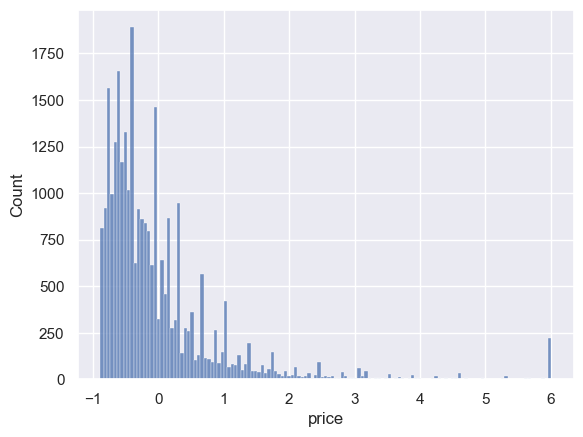

In [7]:
sns.histplot(data=df, x="price")

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price_standardized', ylabel='Count'>

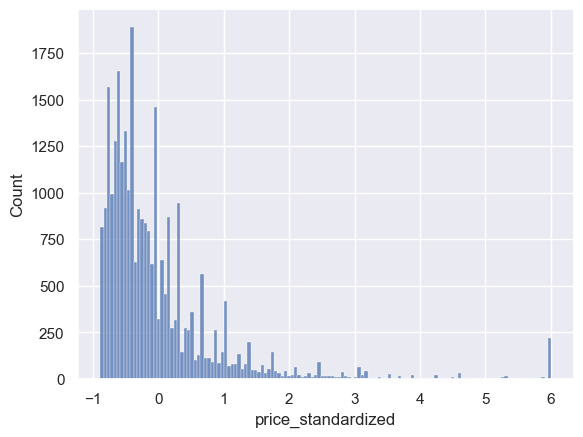

In [8]:
# attempting to standardize the price

scaler = StandardScaler()

df['price_standardized'] = scaler.fit_transform(np.array(df['price']).reshape(-1, 1))

sns.histplot(data=df, x="price_standardized")




/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price_diff', ylabel='Count'>

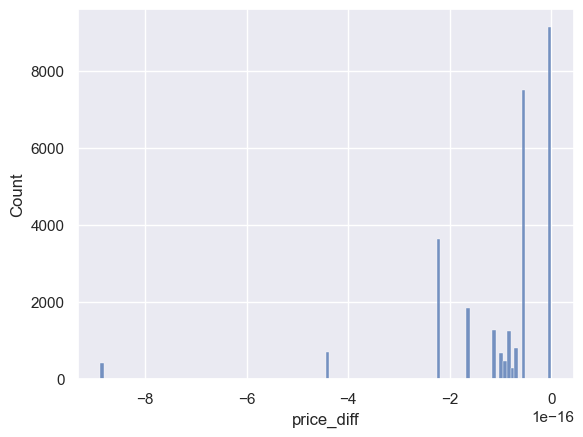

In [9]:
df['price_diff'] = df['price'] - df['price_standardized']
sns.histplot(data=df, x="price_diff")

### Determine which features have the highest variance

In [10]:
# Define the maximum number of columns/features to display variance info about
TOP_NUM_OF_FEAT_VARIANCE = 10

# create a list of the features that are numeric
numeric_column_names = df.select_dtypes(include=np.number).columns.tolist()

# If the user specifies more features/columns than are available, then just
# use all of them
TOP_NUM_OF_FEAT_VARIANCE = min(TOP_NUM_OF_FEAT_VARIANCE,
                               len(numeric_column_names)-1)

# create a dataframe that describes just the numeric features
df_numeric_desc = df[numeric_column_names].describe(include='all')

# https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html
print('Numerical features with the highest variance')
df_numeric_desc.loc['std'].sort_values(ascending=False)[0:TOP_NUM_OF_FEAT_VARIANCE-1]

Numerical features with the highest variance


maximum_nights            1.000018
bathrooms                 1.000018
minimum_nights            1.000018
minimum_minimum_nights    1.000018
maximum_minimum_nights    1.000018
availability_60           1.000018
availability_90           1.000018
number_of_reviews         1.000018
number_of_reviews_ltm     1.000018
Name: std, dtype: double[pyarrow]

# Plot a histagram for a specific feature

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price', ylabel='Count'>

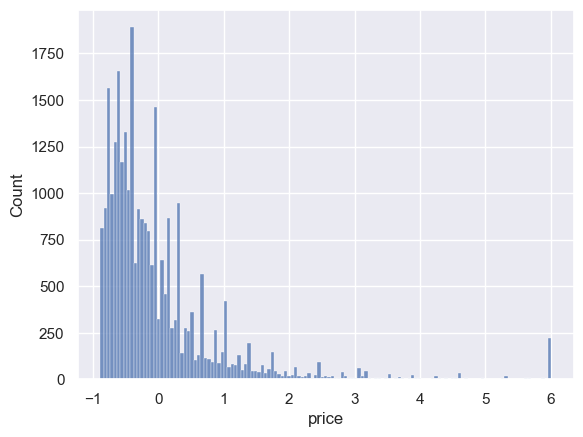

In [11]:
# plot on a specific feature using Seaborn
sns.histplot(data=df, x="price")

# optionally save it as a PNG file
# plt.savefig(rootdir + '/histogram-age.png')

### Count the number of rows with missing values
Ordered by most to fewest missing values

In [12]:
nan_count = np.sum(df.isnull(), axis = 0).sort_values(ascending=False)
nan_count

host_is_superhost                               0
host_has_profile_pic                            0
number_of_reviews_l30d                          0
review_scores_rating                            0
review_scores_cleanliness                       0
review_scores_checkin                           0
review_scores_communication                     0
review_scores_location                          0
review_scores_value                             0
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
n_host_verifications                            0
neighbourhood_group_cleansed_Bronx              0
neighbourhood_group_cleansed_Brooklyn           0
neighbourhood_group_cleansed_Manhattan          0
neighbourhood_group_cleansed_Queens             0
neighbourhood_group_cleansed_Staten Island      0


# Looking for outliers


### Method 1: Calculating the min and max z-scores for each numeric column

Ideally the z-scores should vary between [-2,2] aka 95%, or [-3,3] aka 99.7%

In [13]:
# initialize empty dict for storing results inside the loop
# TODO: convert into simpler format

schema={'Column Name': 'object',
        'Z-Score Min': 'float64',
        'Z-Score Max': 'float64',
        'Max Abs Zscore': 'float64'}

df_zscores = pd.DataFrame(columns=schema.keys()).astype(schema)

for column in numeric_column_names:
    a = max(stats.zscore(df[column], axis=None))
    b = min(stats.zscore(df[column], axis=None))
    c = max(abs(a), abs(b))
    new_row = pd.DataFrame([{'Column Name': column,
           'Z-Score Min': a,
           'Z-Score Max': b,
           'Max Abs Zscore': c}])
    df_zscores = pd.concat([df_zscores, new_row], ignore_index=True)

df_zscores.reset_index()
df_zscores.sort_values('Max Abs Zscore', ascending=False, inplace=True)

# last - for display
df_zscores.round(2).head(20)

ArrowInvalid: Array arguments must all be the same length

### Finding outliers - Method 2: using the Interquadrant Range

In [ ]:
print(f'Number of samples outside IQR for column, out of {num_rows} total rows:')
IQR_FORMAT_STRING="{:<20} {:<8} {:<4.3}%"

iqr_outlier_dict = {}

# iterate through each numeric column
for column in numeric_column_names:
    # define first and third quartiles
    Q3 = np.quantile(df[column], 0.75)
    Q1 = np.quantile(df[column], 0.25)
    IQR = Q3 - Q1
    # calculate the number of samples outside that range
    s = ((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))).sum()
  
    iqr_outlier_dict[column] = s

iqr_outlier_list = sorted(iqr_outlier_dict.items(), key=lambda x:x[1],
                          reverse=True)

for key, val in iqr_outlier_list:
    iter_percentage = val / num_rows * 100.0
    print(IQR_FORMAT_STRING.format(key, val, iter_percentage))

Number of samples outside IQR for column, out of 28022 total rows:
bedrooms             5869     20.9%
calculated_host_listings_count_private_rooms 4533     16.2%
host_listings_count  4473     16.0%
host_total_listings_count 4473     16.0%
bathrooms            4239     15.1%
number_of_reviews_ltm 4215     15.0%
neighbourhood_group_cleansed_Queens 4003     14.3%
calculated_host_listings_count 3869     13.8%
number_of_reviews    3401     12.1%
calculated_host_listings_count_entire_homes 3346     11.9%
number_of_reviews_l30d 3127     11.2%
review_scores_communication 3009     10.7%
review_scores_checkin 2831     10.1%
reviews_per_month    2522     9.0 %
availability_30      2411     8.6 %
host_acceptance_rate 2209     7.88%
price                1903     6.79%
review_scores_location 1863     6.65%
host_response_rate   1670     5.96%
review_scores_cleanliness 1659     5.92%
beds                 1619     5.78%
review_scores_value  1262     4.5 %
review_scores_rating 1190     4.25%
accommodat

# Identify features for potential one-hot encoding
Locate features that have fewer than 10 unique values

Display unique values those features

In [ ]:
MAX_UNIQUE_COLUMN_VALUES = 10

# get a Pandas Series that describes ALL of the column names and # of
# unique values in each column/feature
unique_column_names = df.describe(include='all').loc['unique']

# get the top MAX_UNIQUE_COLUMN_VALUES of features that have the least
# prevalent unique values, store in a List
column_names_with_few_unique_values = unique_column_names.loc[unique_column_names <= MAX_UNIQUE_COLUMN_VALUES].index.tolist()

# initialize an empty dict that will store results in the loop
interesting_columns_with_few_unique = {}

# loop through the column names that have the fewest unique values
for i in column_names_with_few_unique_values:
    # create/assign a value
    interesting_columns_with_few_unique[i] = df[i].unique().tolist()

# display the result
interesting_columns_with_few_unique

{'host_is_superhost': [False, True],
 'host_has_profile_pic': [True, False],
 'host_identity_verified': [True, False],
 'has_availability': [True, False],
 'instant_bookable': [False, True]}

### Looking at columns that are strings for potential One Hot Encoding
Displays a list of the features (with a datatype of string) in ascending order of fewest to most number of unique values.

In [ ]:
# define a list of the column names that represent strings
list_of_string_columns = df.select_dtypes(include=object).columns.tolist()

# create a Pandas Series that lists the string columns by ascending counts
df_unique_string_vals = df[list_of_string_columns].nunique().sort_values(ascending=True)
df_unique_string_vals

Series([], dtype: float64)

# Investigating feature and label correlations
## Plot features against each other to look for relations

Ideally want each feature to have:
* 0 correlation with each other feature
* a correlation of -1 or 1 to the label/target

In [ ]:
# create a list of columns to analyze, ignore anything with "weight" in it
# some of my data sets use the phrase "weight" to indicate the weight for

# each example

# Define the list of columns to analyze, by default it will just do the numeric
# columns
columns_to_analyze = numeric_column_names

# create a copy for pairplot
df_numerical_only = df[columns_to_analyze].copy()

# plot it, but only the bottom left triangle/corner, don't need the repeated
# information since it is symmetric
#sns.pairplot(data=df_numerical_only, corner=True)

## Comparing the features to each other with labels

Plots correlations between all the features, also include the label if available

(this is very inefficent with memory for large datsets)


In [ ]:
# If the label is defined:
if LABEL_COLUMN_NAME is not None:
    # add the label column name
    columns_to_analyze.append(LABEL_COLUMN_NAME)
    print(columns_to_analyze)
    # create a copy and plot it
    df_numerical_only = df[columns_to_analyze].copy()
    #sns.pairplot(data=df_numerical_only, hue = LABEL_COLUMN_NAME,
    #             plot_kws={'s':3}, corner=True)
else:
    # if the label is NOT defined:
    df_numerical_only = df[columns_to_analyze].copy()
    sns.pairplot(data=df_numerical_only, plot_kws={'s':3}, corner=True)

['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'n_host_verifications', 'neighbourhood_group_cleansed_Bronx', 'neighbourhood_group_cleansed_Brooklyn', 'neighbourhood_group_cleansed_Manhattan', 'n

### Correlation Matrix

Analyze the (numeric) columns for correlations

In [ ]:
# create a new dataframe that is the correlation matrix of just the
# numeric columns
df_numeric_only_corr = df_numerical_only.corr()

# create another new dataframe that is the lower triangle of the
# previous result
df_lt = df_numeric_only_corr.where(np.tril(np.ones(df_numeric_only_corr.shape)).astype(np.bool))

# display the simlified correlation matrix for just numeric columns:
df_lt.round(1)

/var/folders/90/cd8pt9qd43q0svfjsljg9ccr0000gn/T/ipykernel_53976/2524499908.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_lt = df_numeric_only_corr.where(np.tril(np.ones(df_numeric_only_corr.shape)).astype(np.bool))


,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,price
host_response_rate,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_acceptance_rate,0.4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_listings_count,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_total_listings_count,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accommodates,0.0,0.1,-0.0,-0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,0.0,-0.0,0.0,0.0,0.4,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,0.0,0.0,-0.0,-0.0,0.7,0.5,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
beds,0.0,0.0,-0.0,-0.0,0.8,0.4,0.7,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,0.0,0.0,0.1,0.1,0.5,0.3,0.5,0.4,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
minimum_nights,-0.1,-0.1,0.0,0.0,-0.1,-0.0,-0.0,-0.1,-0.1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


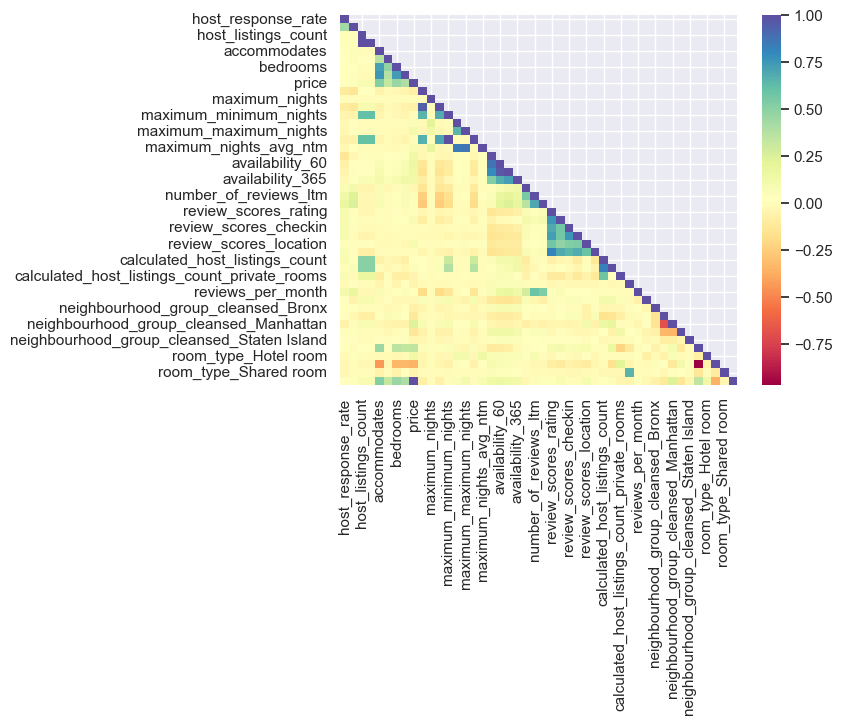

In [ ]:
# display a heatmap of the simplified correlation matrix of just
# the numeric columns
hmap=sns.heatmap(df_lt, cmap="Spectral")

### Correlated columns chart

Display a list of the correlated columns in order from highest correlation (in magnitude, closest to -1 or 1) to lowest correlation (closest to zero). We don't care about the sign of the correlation, just the magnitude (absolute value).

In [ ]:
# intialize an empty list to store results
res = []

# iterate through the column names in alphabetical order for horizontal
for col1 in sorted(df_lt.columns):

    # iterate through the column names in alphabetical order for vertial
    for col2 in sorted(df_lt.columns):
        try:
            # extract the correlation value
            val = df_lt[col1][col2]

            # if the column names match, then skip this one, their correlation 
            # will be one also skip if the answer is None / which is for the top
            # right symmetric portion
            if col1 == col2 or isnan(val):
                continue
        
            # create a name that describes the two columns
            new_col_name = f'{col1}__vs__{col2}'
        
            # add this to the resulting list
            # the first column is the absolute value of the correlation,

            # since I want to sort them by descending magnitude
            res.append([abs(val), val, new_col_name ])
        except:
            continue

# sort the list from highest magnitude to lowest
# the features with the highest correlation with each other may want
# to be removed
res = sorted(res, reverse=True)

# create a format string to design the output table
# < is left aligned     . is sig digs
CORRELATION_VS_COLNAME_FORMAT_STR = "{:>18.3}   {:<36}"

print("Most to least correlated features\n")
print("Correlation [-1,1]   Features/Columns")
print("-------------------------------------")
# loop through and display the relevant results:
for i, correlation, vs_col_name in res:
    print(CORRELATION_VS_COLNAME_FORMAT_STR.format(correlation, vs_col_name))

Most to least correlated features

Correlation [-1,1]   Features/Columns
-------------------------------------
               1.0   host_listings_count__vs__host_total_listings_count
             0.998   maximum_minimum_nights__vs__minimum_nights_avg_ntm
             0.969   availability_60__vs__availability_90
            -0.963   room_type_Entire home/apt__vs__room_type_Private room
             0.942   minimum_nights__vs__minimum_minimum_nights
             0.872   availability_30__vs__availability_60
             0.868   maximum_maximum_nights__vs__maximum_nights_avg_ntm
             0.844   minimum_maximum_nights__vs__maximum_nights_avg_ntm
              0.83   calculated_host_listings_count__vs__calculated_host_listings_count_entire_homes
             0.821   review_scores_rating__vs__review_scores_value
             0.786   availability_30__vs__availability_90
             0.758   review_scores_rating__vs__review_scores_cleanliness
             0.756   review_scores_checkin__vs_